In [7]:
import kagglehub
puneet6060_intel_image_classification_path = kagglehub.dataset_download('puneet6060/intel-image-classification')

print('Data source import complete.')


Data source import complete.


---

##  Dataset Overview: Intel Image Classification

###  Source:

This dataset is provided by Intel and is commonly used in computer vision tasks for natural scene classification. It includes thousands of labeled landscape images across multiple categories.

###  Objective:

To build a model that can accurately classify an image into one of six different natural scene categories.

---

##  Dataset Structure

The dataset is organized into three main folders:

| Folder Name | Description                                          |
| ----------- | ---------------------------------------------------- |
| `seg_train` | Labeled training images (organized by class folders) |
| `seg_test`  | Labeled test images (same structure as training)     |
| `seg_pred`  | Unlabeled images (used for prediction tasks)         |

Each image is stored in a subdirectory named after its class. These subfolder names are automatically used as labels by PyTorch’s `ImageFolder`.

---

##  Class Labels

There are 6 distinct classes in the dataset:

| Class Name  | Description                    | Label Index |
| ----------- | ------------------------------ | ----------- |
| `buildings` | Urban buildings and structures | 0           |
| `forest`    | Forests and tree-covered areas | 1           |
| `glacier`   | Snowy/glacial regions          | 2           |
| `mountain`  | Mountains and highlands        | 3           |
| `sea`       | Ocean and coastal areas        | 4           |
| `street`    | Streets and urban roads        | 5           |

> Labels are automatically generated by `ImageFolder` based on alphabetical order of subfolders, i.e., via `.class_to_idx`.

---

##  Image Features

| Feature      | Value                     |
| ------------ | ------------------------- |
| Total Images | \~25,000                  |
| Image Size   | 150 x 150 pixels          |
| Color Mode   | RGB (3 color channels)    |
| File Format  | `.jpg`                    |
| Type of Data | Natural scene photographs |

All images are uniformly sized and RGB formatted, making them directly usable in deep learning pipelines. There are no separate metadata or tabular features — the model learns directly from image pixels.

---


# Import Required Libraries

In [2]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torchvision
from PIL import Image
import math

# Set device

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


# Define paths

In [ ]:
train_dir = r"C:\Users\basav\Deep_Learning\college_cv\intel_image_class\seg_train\seg_train"
test_dir = r"C:\Users\basav\Deep_Learning\college_cv\intel_image_class\seg_test\seg_test"
pred_dir = r"C:\Users\basav\Deep_Learning\college_cv\intel_image_class\seg_pred\seg_pred"

# Define transforms

In [10]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load datasets

In [11]:
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes
print("Classes:", class_names)


Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


# Visualize training samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4285715].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to

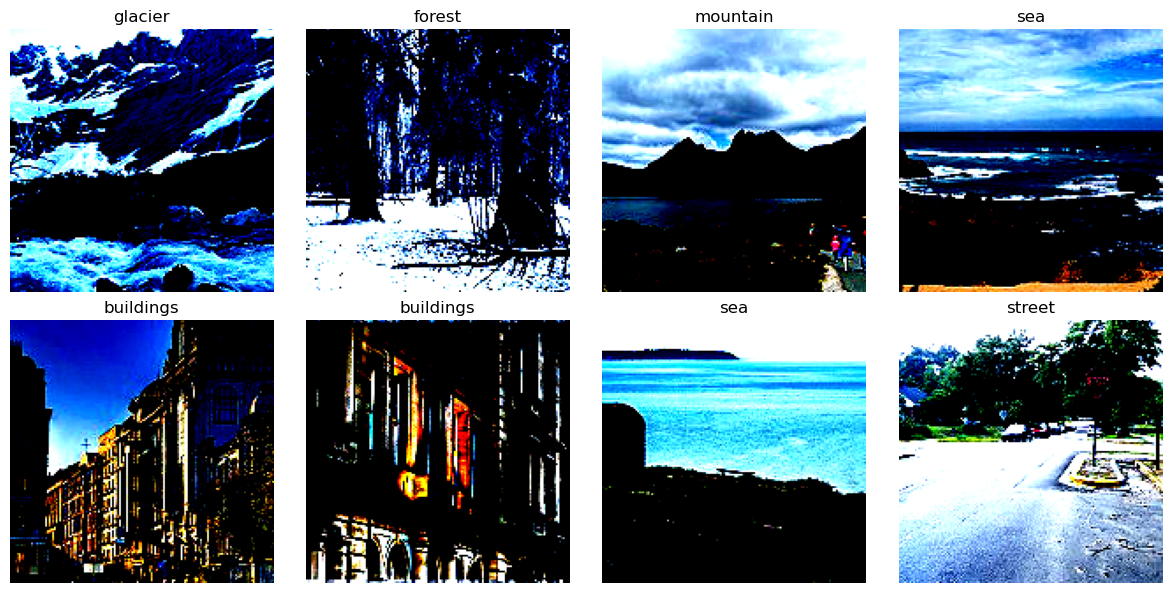

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Class names
class_names = train_dataset.classes

# Get one batch
images, labels = next(iter(train_loader))

# Function to convert tensor to numpy image
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))  # [C,H,W] → [H,W,C]
    plt.imshow(img)
    plt.axis('off')

# Plot first 8 images
plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    imshow(images[i])
    plt.title(class_names[labels[i]])
plt.tight_layout()
plt.show()


# Define CNN model

In [13]:
import torch.nn as nn

class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),          # Added BatchNorm
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),          # Added BatchNorm
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),         # Added BatchNorm
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Linear(128 * 18 * 18, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# Initialize model with number of classes
model = CNNModel(len(class_names)).to(device)


# Loss and optimizer

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training

In [15]:
# Store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
# Best model tracking
best_val_accuracy = 0.0
def train_model(model, epochs=10):
    global best_val_accuracy
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        train_loss = total_loss / len(train_loader)
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss)

        # ----- Validation loop -----
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_accuracy = 100 * val_correct / val_total
        val_loss /= len(test_loader)
        val_accuracies.append(val_accuracy)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")
        
        # Save best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_val_model.pth')
            print(f"Saved Best Model at Epoch {epoch+1} with Val Accuracy: {val_accuracy:.2f}%")
train_model(model, epochs=10)
# Save final model
torch.save(model.state_dict(), 'final_model.pth')
print("✅ Final model saved as final_model.pth")

KeyboardInterrupt: 

# Evaluation on test set

In [ ]:
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 83.97%


# Confusion Matrix

<Figure size 800x600 with 0 Axes>

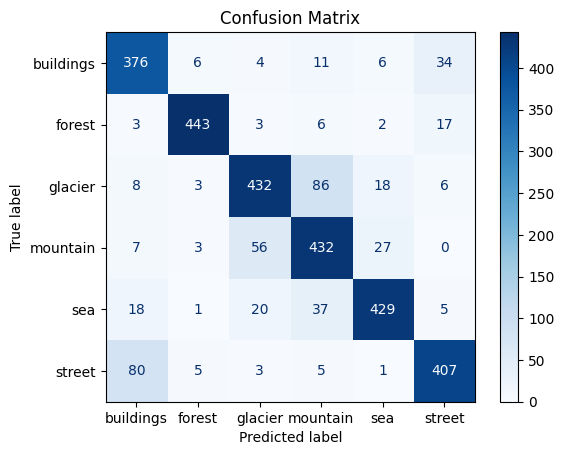

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

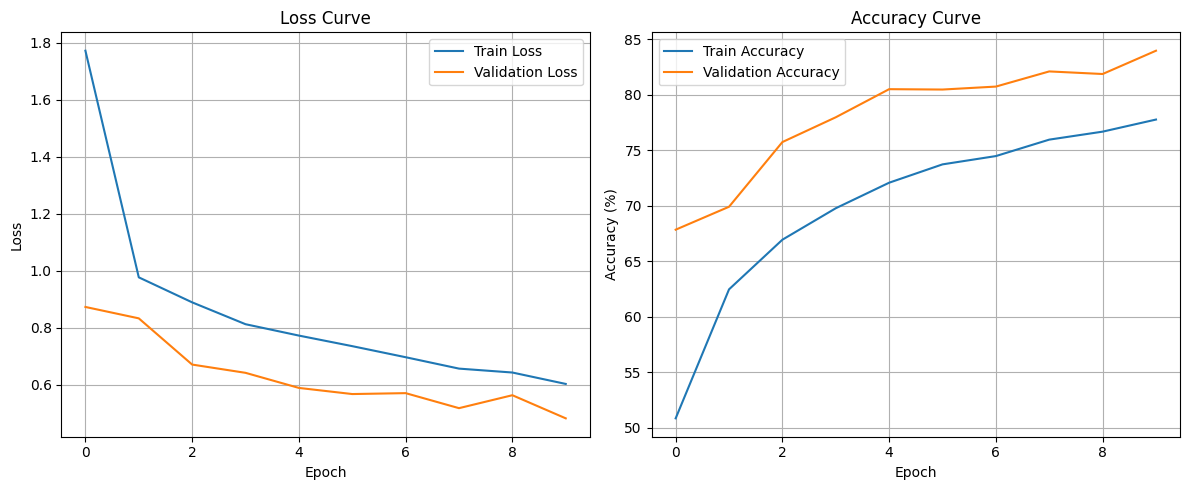

In [ ]:
# Plot Loss Curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

# Plot Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


# Predict for images in seg_pred

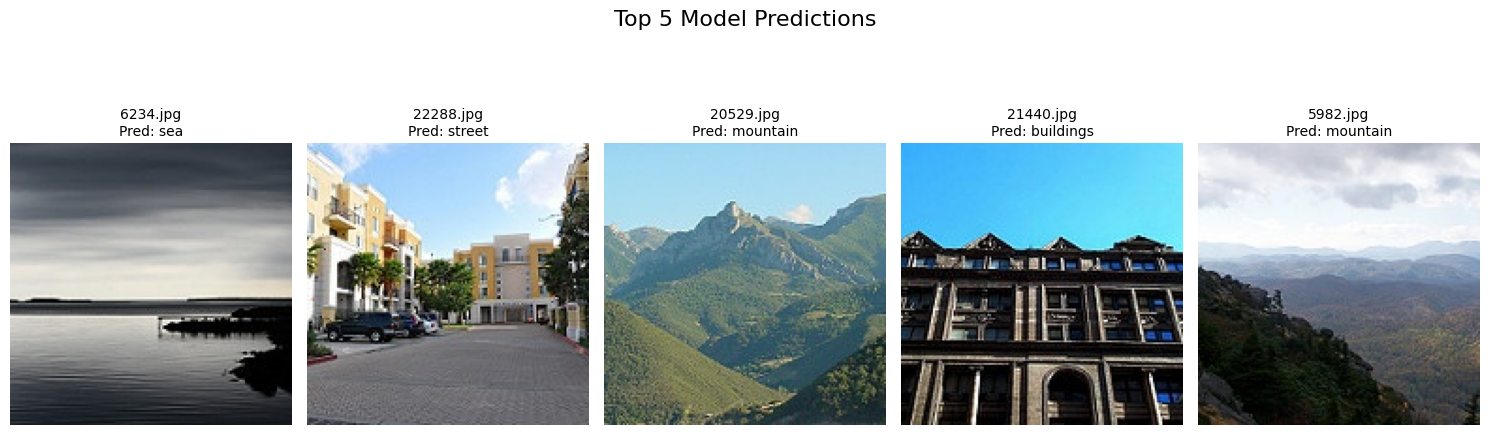

In [ ]:
import os
import torch
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt

# Use same transform as training
pred_transform = transform

# Get all files in pred_dir (no extension filtering)
all_files = [os.path.join(pred_dir, f) for f in os.listdir(pred_dir)]

results = []

# Predict using model
model.eval()
with torch.no_grad():
    for file_path in all_files:
        try:
            img = Image.open(file_path).convert("RGB")  # Try to open as image
            input_tensor = pred_transform(img).unsqueeze(0).to(device)

            output = model(input_tensor)
            _, predicted = torch.max(output, 1)
            label = class_names[predicted.item()]
            results.append((os.path.basename(file_path), label))
        except UnidentifiedImageError:
            print(f"Skipped non-image file: {file_path}")
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

# Show top 5 predicted images
n_show = min(5, len(results))
plt.figure(figsize=(15, 5))
for i, (fname, label) in enumerate(results[:n_show]):
    img_path = os.path.join(pred_dir, fname)
    img = Image.open(img_path)

    plt.subplot(1, n_show, i + 1)
    plt.imshow(img)
    plt.title(f"{fname}\nPred: {label}", fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.suptitle("Top 5 Model Predictions", fontsize=16, y=1.05)
plt.show()
